In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [ ]:
!pip install tf-nightly-gpu

In [ ]:
!pip install import_ipynb

In [ ]:
#ipynb 모듈 불러오기 위한 설정(model import)
import sys
sys.path.append('/content/gdrive/My Drive/CNN/')
sys.path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.preprocessing import image

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import pickle

from PIL import Image

## 예측, Grad CAM 함수

In [ ]:
def model_predict(model, class_index, label):
    files_name=[]
    predics=[]
    labels=[]

    for i in range(len(class_index)):
        if i % 100 == 0:
          print(i, end=', ')
        test_path = '/content/gdrive/My Drive/dataset/test/{}/{}'.format(class_index[i][:3], class_index[i])
        test_image = Image.open(test_path).resize((224, 224))

        img_tensor = np.array(test_image)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        test_data = img_tensor / 255.0

        pred = model.predict(test_data)

        files_name.append(class_index[i])
        predics.append(pred)
        labels.append(label)

    re_dic = dict({'files':files_name, 'pred':predics, 'labels':labels})

    return re_dic

In [ ]:
def grad_cam(model, class_predict):
    plt.figure(figsize=(32, 32))

    for i in range(len(class_predict['pred'])): 
        path = os.path.join('/content/gdrive/My Drive/dataset/test/{}/{}'.format(class_predict['files'][0][:3], class_predict['files'][i]))
        image = cv2.imread(path)
        img = cv2.resize(image, (224, 224))
        x = img.copy()
        x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
          
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(index=23).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(x, tf.float32)
            model_outputs, predictions = grad_model(inputs)
            loss = predictions[:,0]

        grads = tape.gradient(loss, model_outputs)

        guided_grads = (
              tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        )

        prediction = predictions[0]
        model_outputs = model_outputs[0]

        plt.subplot((len(class_predict['pred']) / 3) + 1, 3, i + 1)
        plt.suptitle('{} Grad CAM'.format(class_predict['files'][0][:3]))
        plt.title('%s, pred: %0.4f'%(class_predict['files'][i], class_predict['pred'][i]))

        weights = np.mean(grads, axis=(1, 2))
        weights = weights.reshape(512, 1)

        cam = (prediction -0.5) * np.matmul(model_outputs, weights)
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam -= 0.2
        cam /= 0.8

        try:
          cam = cv2.resize(np.float32(cam), (224, 224))
        except Exception as e: 
          print(str(e))

        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0
        grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
        plt.axis('off')
        plt.imshow(grad_cam[:, :, ::-1])

In [ ]:
def grad_cam_save(model, class_predict):
    for i in range(len(class_predict['pred'])): 
        path = os.path.join('/content/gdrive/My Drive/dataset/test/{}/{}'.format(class_predict['files'][0][:3], class_predict['files'][i]))
        image = cv2.imread(path)
        img = cv2.resize(image, (224, 224))
        x = img.copy()
        x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
          
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(index=23).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(x, tf.float32)
            model_outputs, predictions = grad_model(inputs)
            loss = predictions[:,0]

        grads = tape.gradient(loss, model_outputs)

        guided_grads = (
              tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        )

        prediction = predictions[0]
        model_outputs = model_outputs[0]

        plt.title('%s, pred: %0.4f'%(class_predict['files'][i], class_predict['pred'][i]))

        weights = np.mean(grads, axis=(1, 2))
        weights = weights.reshape(512, 1)

        cam = (prediction -0.5) * np.matmul(model_outputs, weights)
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam -= 0.2
        cam /= 0.8

        try:
          cam = cv2.resize(np.float32(cam), (224, 224))
        except Exception as e: 
          print(str(e))

        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0
        grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(grad_cam[:, :, ::-1])
        plt.savefig('/content/gdrive/My Drive/dataset/Grad_CAM/{}/dog_0/{}'.format(class_predict['files'][i][:3], class_predict['files'][i]))
        plt.close()

## 모델 예측할 테스트 데이터 가져오기

In [ ]:
test_path = '/content/gdrive/My Drive/dataset/test/'

cat_path = os.path.join(test_path, os.listdir(test_path)[0])
dog_path = os.path.join(test_path, os.listdir(test_path)[1])

cat_files = os.listdir(cat_path)
dog_files = os.listdir(dog_path)

## 데이터 분석을 위한 학습된 모델 가져오기(VggNet Layer 16 epoch 250    -    Accuracy 95.05%, Loss 0.1351)

In [ ]:
get_model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/vgg16_epoch250.h5')

## 고양이 예측하고 맞은 것과 틀린 것 분류하기

In [ ]:
cats_predict = model_predict(get_model, cat_files, 0)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 

In [ ]:
for i in range(10):
    print(cats_predict['files'][i], cats_predict['pred'][i][0][0], cats_predict['labels'][i])

cat.10000.jpg 1.4203792e-05 0
cat.10001.jpg 0.00028218416 0
cat.10003.jpg 0.0014604658 0
cat.10002.jpg 0.00056919485 0
cat.10005.jpg 0.0016099595 0
cat.10004.jpg 5.1835326e-05 0
cat.10006.jpg 0.00012686713 0
cat.10007.jpg 0.00031506454 0
cat.10008.jpg 0.015369447 0
cat.10011.jpg 0.02149916 0


In [ ]:
cats_0_name = []
cats_0_pred = []
cats_1_name = []
cats_1_pred = []

for i in range(len(cats_predict['pred'])):
    if cats_predict['pred'][i][0][0] > 0.500:
        cats_1_name.append(cats_predict['files'][i])
        cats_1_pred.append(cats_predict['pred'][i][0][0])
    else:
        cats_0_name.append(cats_predict['files'][i])
        cats_0_pred.append(cats_predict['pred'][i][0][0])

cat_0 = dict({'files':cats_0_name, 'pred':cats_0_pred})        
cat_1 = dict({'files':cats_1_name, 'pred':cats_1_pred})

In [ ]:
print('맞은 것')
for i in range(10):
    print(cat_0['files'][i], cat_0['pred'][i])
print('틀린 것')
for i in range(10):  
    print(cat_1['files'][i], cat_1['pred'][i])

맞은 것
cat.10000.jpg 1.4203792e-05
cat.10001.jpg 0.00028218416
cat.10003.jpg 0.0014604658
cat.10002.jpg 0.00056919485
cat.10005.jpg 0.0016099595
cat.10004.jpg 5.1835326e-05
cat.10006.jpg 0.00012686713
cat.10007.jpg 0.00031506454
cat.10008.jpg 0.015369447
cat.10011.jpg 0.02149916
틀린 것
cat.10013.jpg 0.9571426
cat.10029.jpg 0.9830872
cat.10037.jpg 0.91560996
cat.10102.jpg 0.9877592
cat.10121.jpg 0.87401557
cat.10129.jpg 0.53454405
cat.10142.jpg 0.8591209
cat.10151.jpg 0.69963217
cat.10167.jpg 0.90335286
cat.10166.jpg 0.51970416


## 개 예측하기

In [ ]:
dogs_predict = model_predict(get_model, dog_files, 1)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 

In [ ]:
for i in range(10):
    print(dogs_predict['files'][i], dogs_predict['pred'][i][0][0], dogs_predict['labels'][i])

dog.10256.jpg 0.6441976 1
dog.10257.jpg 0.78987074 1
dog.1281.jpg 0.99832076 1
dog.1157.jpg 0.9975794 1
dog.1239.jpg 0.9989625 1
dog.1218.jpg 0.9978744 1
dog.1324.jpg 0.699134 1
dog.1297.jpg 0.9999639 1
dog.1269.jpg 0.189052 1
dog.1310.jpg 0.99940217 1


In [ ]:
dogs_0_name = []
dogs_0_pred = []
dogs_1_name = []
dogs_1_pred = []

for i in range(len(dogs_predict['pred'])):
    if dogs_predict['pred'][i][0][0] > 0.500:
        dogs_1_name.append(dogs_predict['files'][i])
        dogs_1_pred.append(dogs_predict['pred'][i][0][0])
    else:
        dogs_0_name.append(dogs_predict['files'][i])
        dogs_0_pred.append(dogs_predict['pred'][i][0][0])

dog_0 = dict({'files':dogs_0_name, 'pred':dogs_0_pred})        
dog_1 = dict({'files':dogs_1_name, 'pred':dogs_1_pred})

In [ ]:
print('맞은 것')
for i in range(10):
    print(dog_0['files'][i], dog_0['pred'][i])
print('틀린 것')
for i in range(10):  
    print(dog_1['files'][i], dog_1['pred'][i])

맞은 것
dog.1269.jpg 0.189052
dog.10261.jpg 0.1652979
dog.1311.jpg 0.040469095
dog.10274.jpg 0.38949603
dog.1288.jpg 0.23447305
dog.1276.jpg 0.062088106
dog.10297.jpg 0.3151932
dog.1226.jpg 0.043297563
dog.1260.jpg 0.43256003
dog.10302.jpg 0.16389525
틀린 것
dog.10256.jpg 0.6441976
dog.10257.jpg 0.78987074
dog.1281.jpg 0.99832076
dog.1157.jpg 0.9975794
dog.1239.jpg 0.9989625
dog.1218.jpg 0.9978744
dog.1324.jpg 0.699134
dog.1297.jpg 0.9999639
dog.1310.jpg 0.99940217
dog.1339.jpg 0.9728363


## 저장하기

- 고양이, 개 예측 데이터(파일명, 예측 점수, 라벨)

  '/content/gdrive/My Drive/dataset/cats_predict.bin'

  '/content/gdrive/My Drive/dataset/dogs_predict.bin'

- 고양이 맞은 것, 틀린 것

  '/content/gdrive/My Drive/dataset/cat_0.bin'

  '/content/gdrive/My Drive/dataset/cat_1.bin' 

- 개 맞은 것, 틀린 것

  '/content/gdrive/My Drive/dataset/dog_0.bin'

  '/content/gdrive/My Drive/dataset/dog_1.bin' 


In [ ]:
with open('/content/gdrive/My Drive/dataset/dog_1.bin', 'wb') as hi:
  pickle.dump(dog_1, hi)

## 맞게 예측한 이미지 Grad CAM 확인하기

#### 고양이

In [ ]:
grad_cam(get_model, cat_0)

In [ ]:
grad_cam_save(get_model, cat_0)

#### 개

In [ ]:
grad_cam(get_model, dog_1)

In [ ]:
grad_cam_save(get_model, dog_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal


## 잘 못 예측한 이미지 Grad CAM 확인하기

#### 고양이

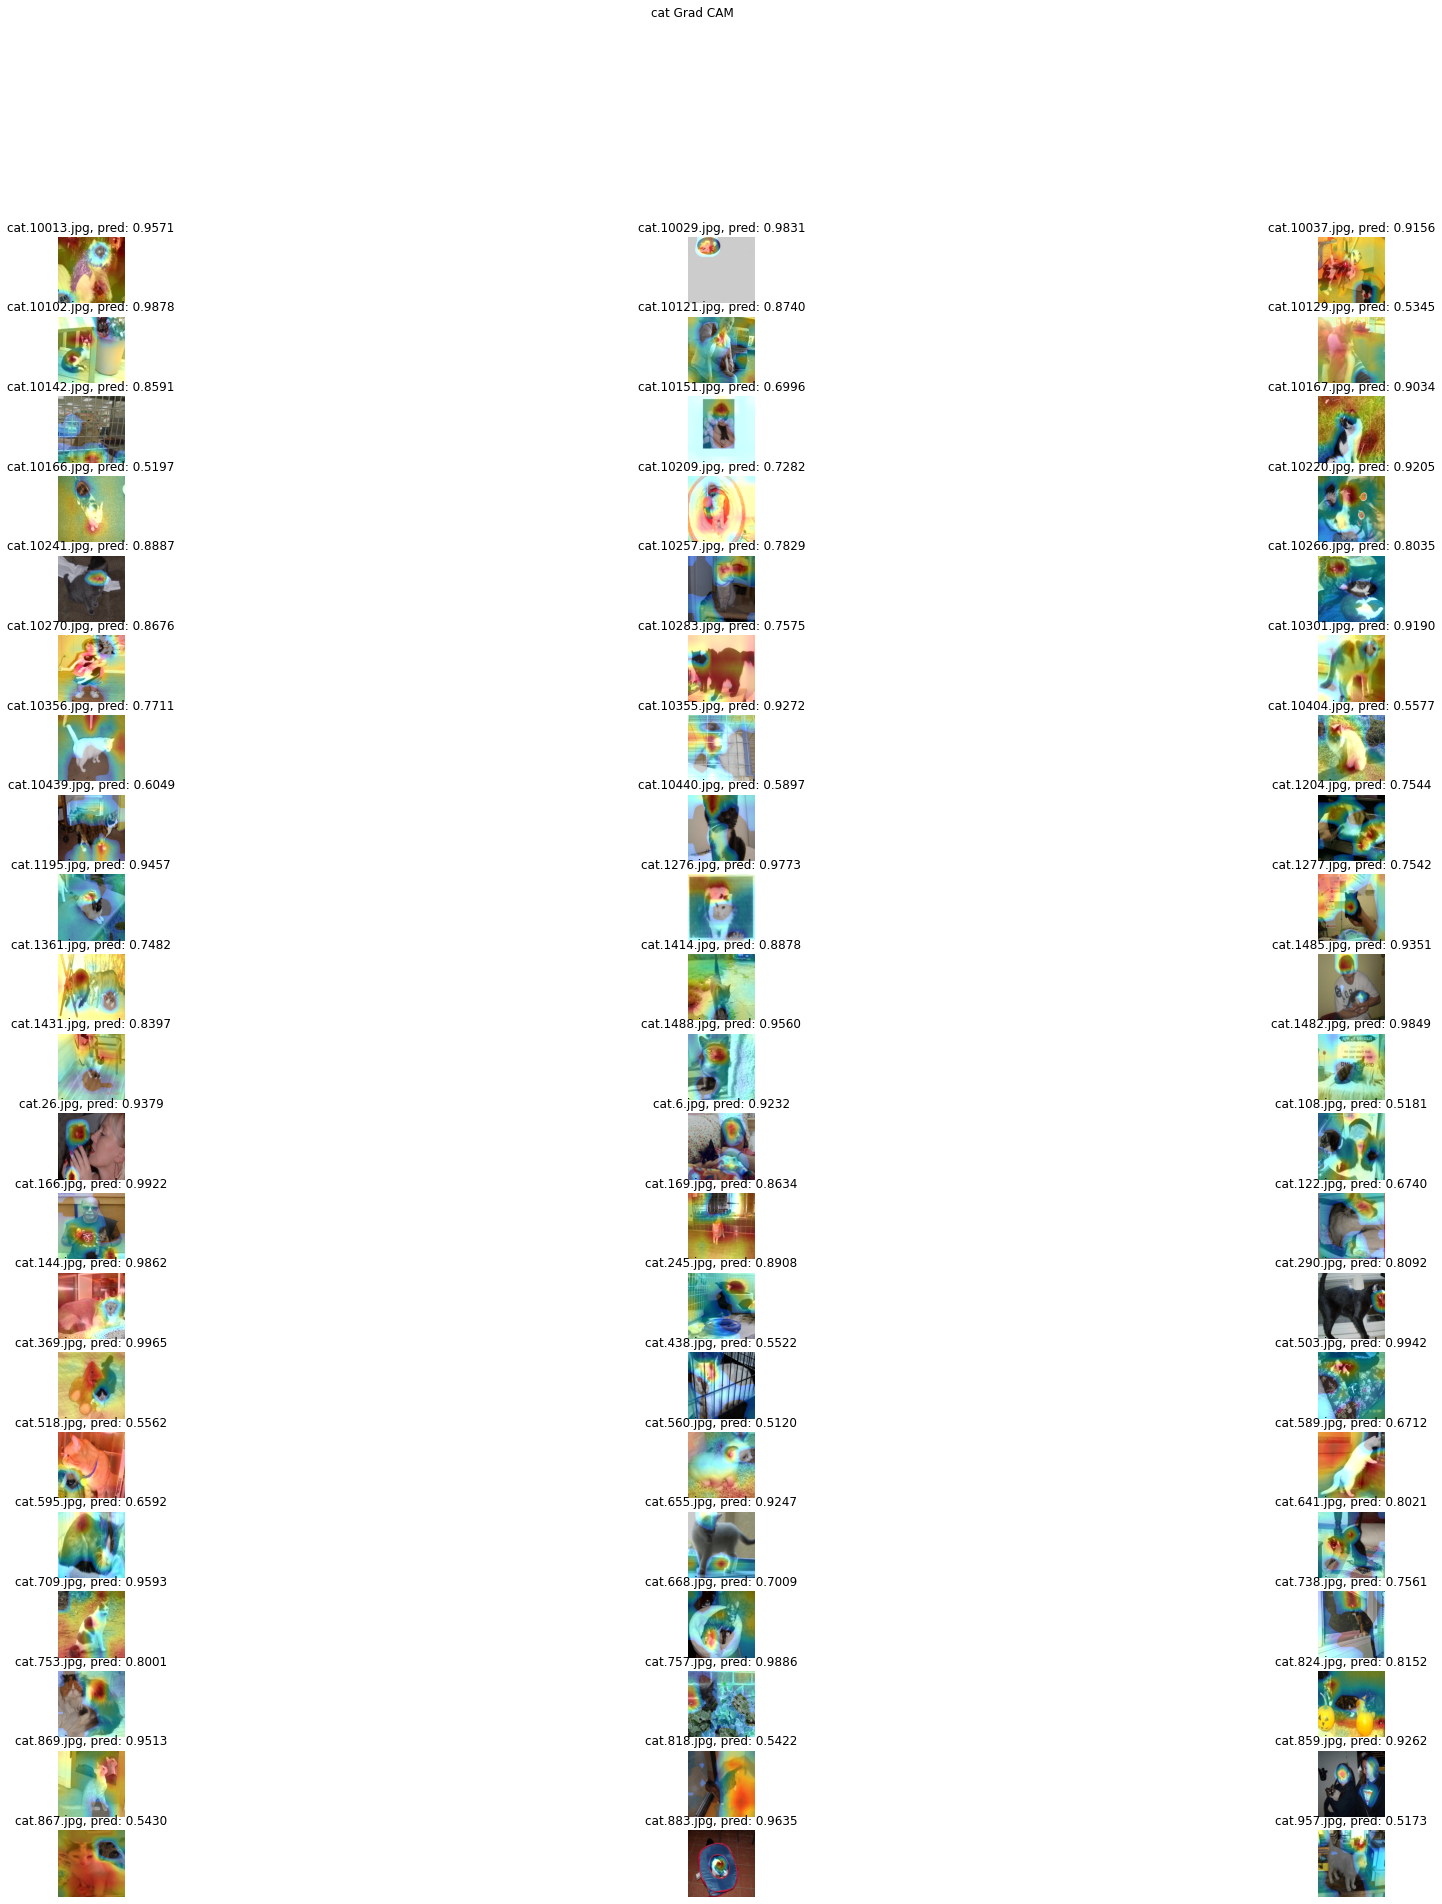

In [ ]:
grad_cam(get_model, cat_1)

In [ ]:
grad_cam_save(get_model, cat_1)

#### 개

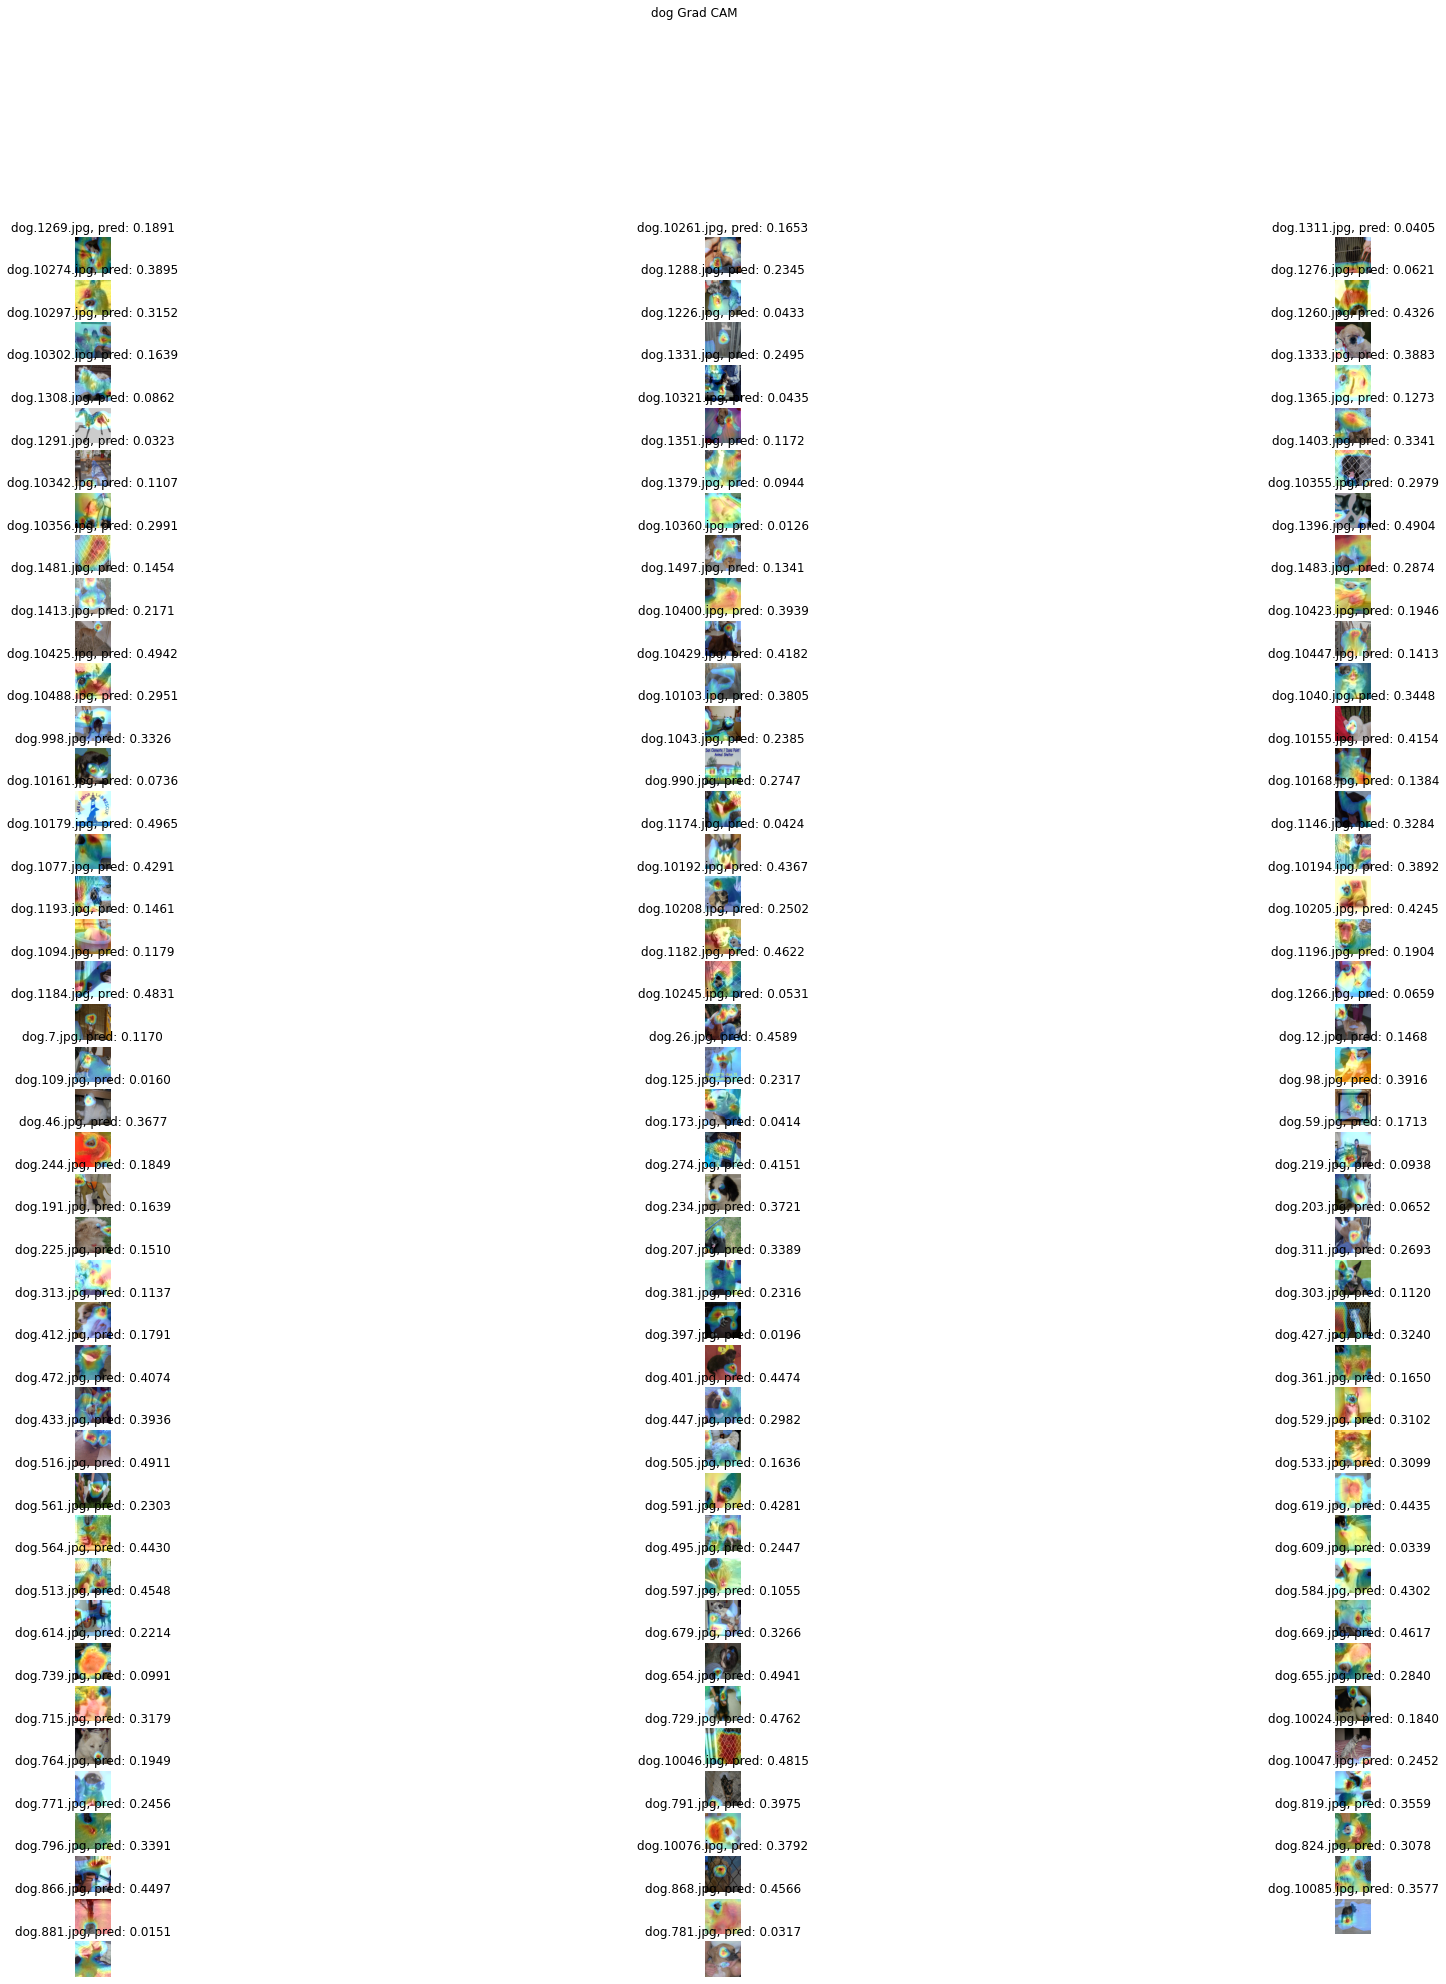

In [ ]:
grad_cam(get_model, dog_0)

In [ ]:
grad_cam_save(get_model, dog_0)

## 예측한 일부 이미지 Grad CAM 확인하기

In [ ]:
cat_1_cam =  os.listdir('/content/gdrive/My Drive/dataset/Grad_CAM/cat/cat_1/')
cat_0_cam =  os.listdir('/content/gdrive/My Drive/dataset/Grad_CAM/cat/cat_0/')
dog_0_cam =  os.listdir('/content/gdrive/My Drive/dataset/Grad_CAM/dog/dog_0/')
dog_1_cam =  os.listdir('/content/gdrive/My Drive/dataset/Grad_CAM/dog/dog_1/')

cat_path = '/content/gdrive/My Drive/dataset/Grad_CAM/cat/'
dog_path = '/content/gdrive/My Drive/dataset/Grad_CAM/dog/'


print(dog_1_cam)

['dog.407.jpg', 'dog.501.jpg', 'dog.487.jpg', 'dog.514.jpg', 'dog.464.jpg', 'dog.451.jpg', 'dog.408.jpg', 'dog.423.jpg', 'dog.479.jpg', 'dog.436.jpg', 'dog.388.jpg', 'dog.544.jpg', 'dog.389.jpg', 'dog.480.jpg', 'dog.437.jpg', 'dog.465.jpg', 'dog.452.jpg', 'dog.502.jpg', 'dog.453.jpg', 'dog.488.jpg', 'dog.545.jpg', 'dog.438.jpg', 'dog.515.jpg', 'dog.530.jpg', 'dog.503.jpg', 'dog.481.jpg', 'dog.466.jpg', 'dog.390.jpg', 'dog.391.jpg', 'dog.482.jpg', 'dog.489.jpg', 'dog.467.jpg', 'dog.559.jpg', 'dog.531.jpg', 'dog.392.jpg', 'dog.546.jpg', 'dog.504.jpg', 'dog.468.jpg', 'dog.560.jpg', 'dog.574.jpg', 'dog.517.jpg', 'dog.483.jpg', 'dog.518.jpg', 'dog.490.jpg', 'dog.532.jpg', 'dog.547.jpg', 'dog.589.jpg', 'dog.575.jpg', 'dog.519.jpg', 'dog.548.jpg', 'dog.590.jpg', 'dog.491.jpg', 'dog.393.jpg', 'dog.576.jpg', 'dog.506.jpg', 'dog.507.jpg', 'dog.577.jpg', 'dog.562.jpg', 'dog.549.jpg', 'dog.492.jpg', 'dog.604.jpg', 'dog.520.jpg', 'dog.563.jpg', 'dog.550.jpg', 'dog.605.jpg', 'dog.493.jpg', 'dog.578.

In [ ]:
def final_grad_cam(path, idx, cam_images):
    plt.figure(figsize=(18, 15))
    for i in range(22, 34):
      grad_cam_image = os.path.join(path + '/{}_{}/{}'.format(cam_images[i][:3], idx, cam_images[i]))
      image = plt.imread(grad_cam_image)
      image = np.array(image)
      img = image / 255.0

      plt.subplot(4, 4, (i-22)+1)
      plt.axis('off')
      plt.imshow(img)

## 맞게 예측한 일부 이미지 Grad CAM 확인하기

#### 고양이

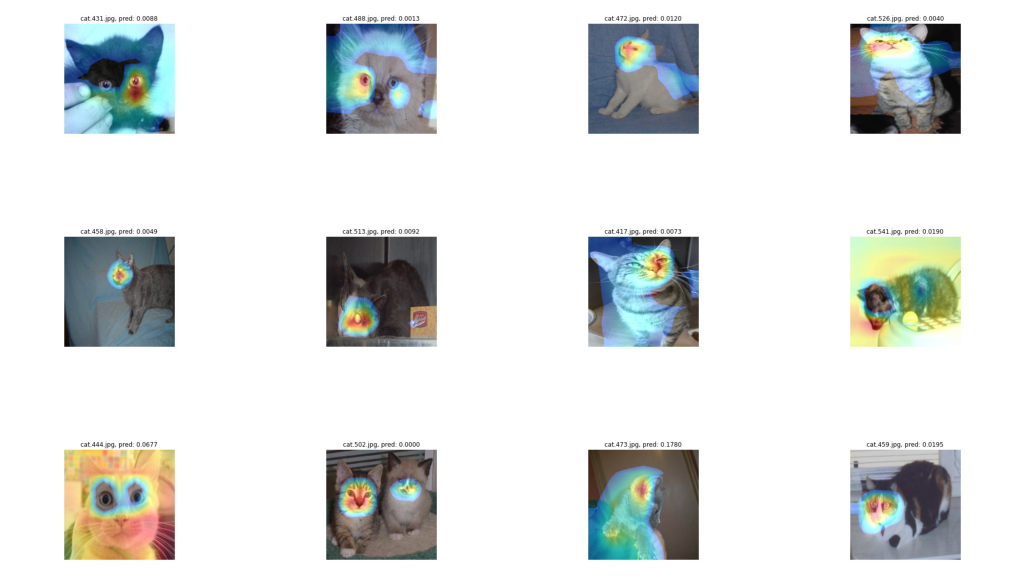

In [ ]:
final_grad_cam(cat_path, 0, cat_0_cam)

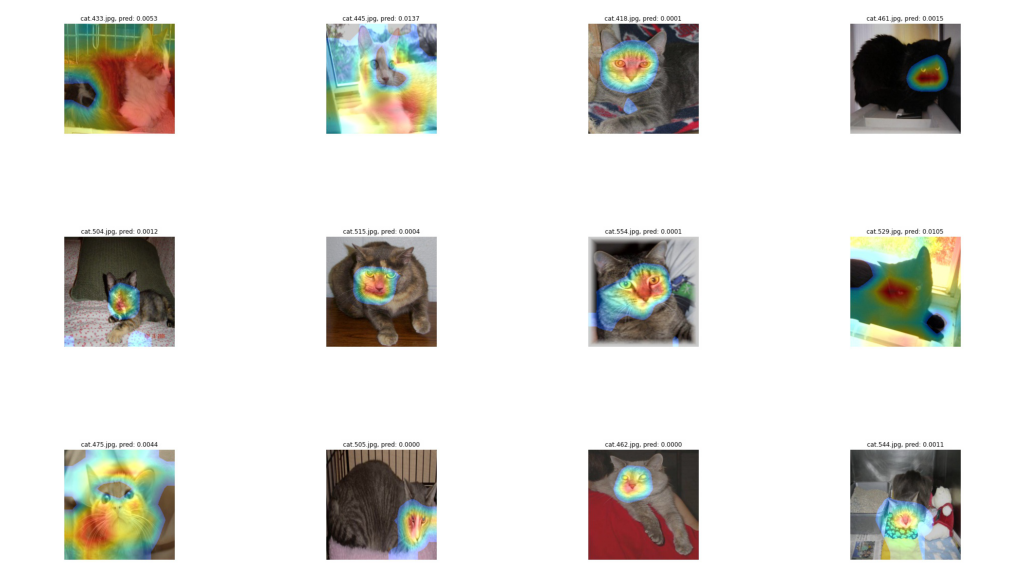

In [ ]:
final_grad_cam(cat_path, 0, cat_0_cam)

## 개

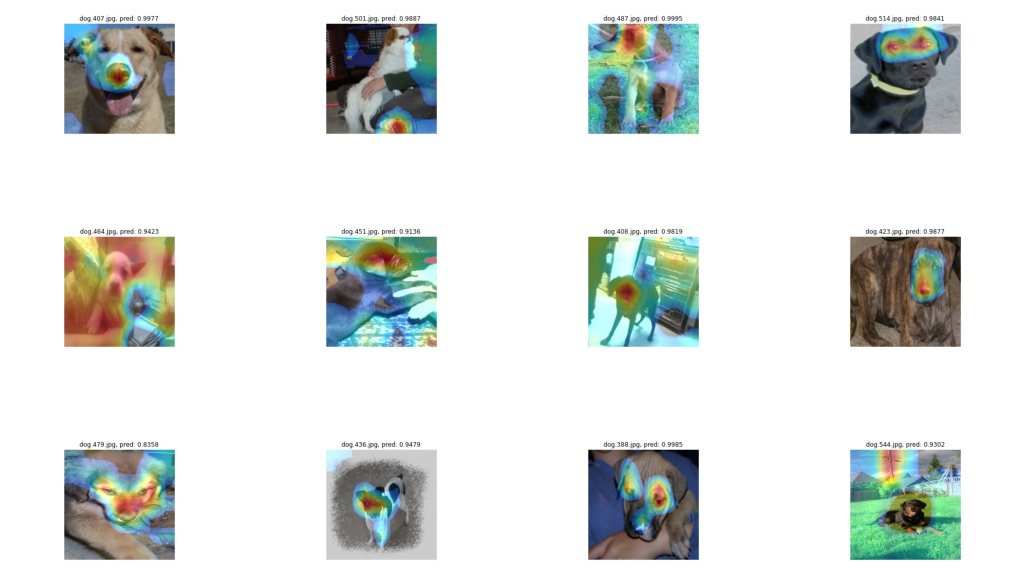

In [ ]:
final_grad_cam(dog_path, 1, dog_1_cam)

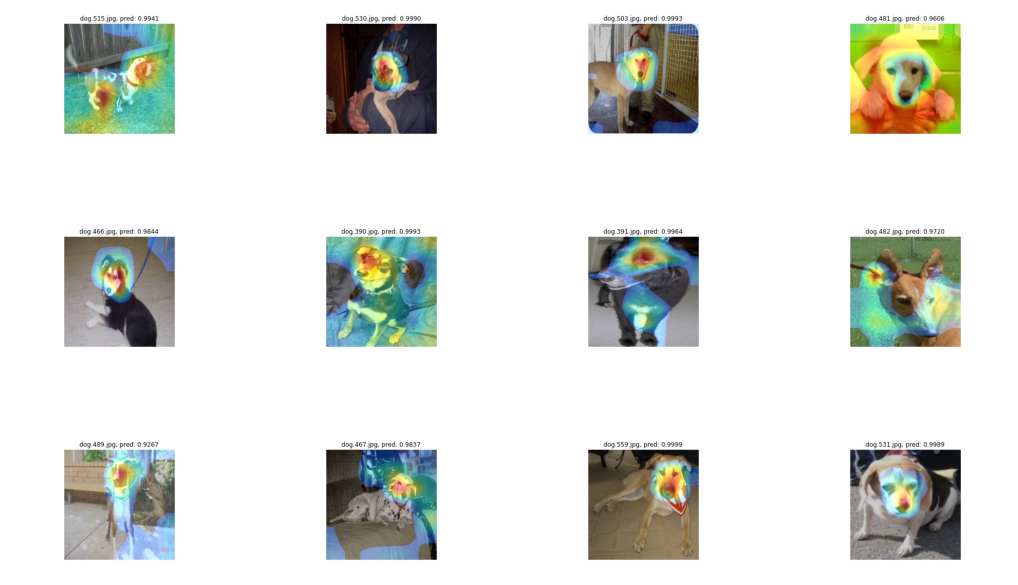

In [ ]:
final_grad_cam(dog_path, 1, dog_1_cam)

## 잘 못 예측한 일부 이미지 Grad CAM 확인하기

## 고양이

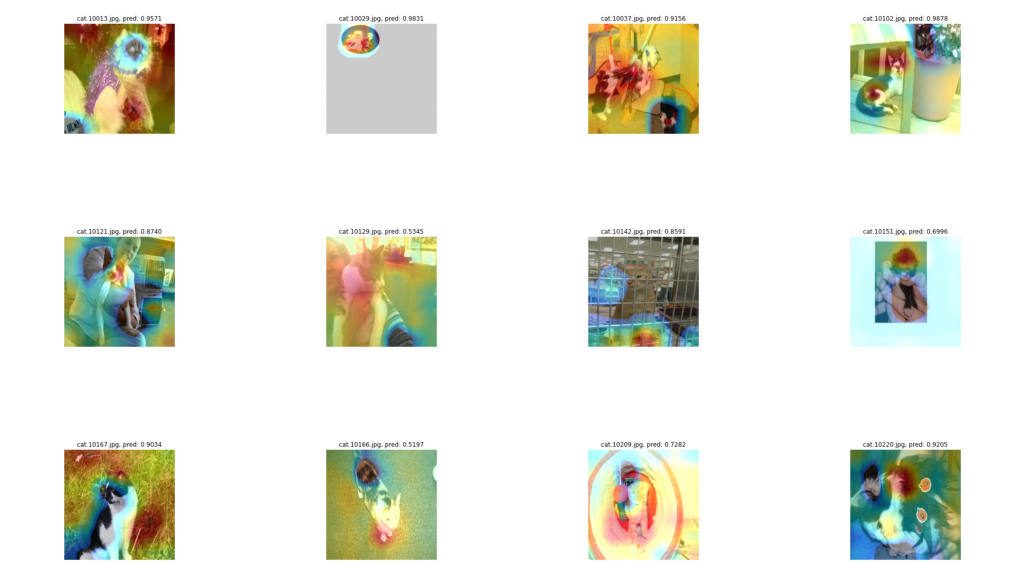

In [ ]:
final_grad_cam(cat_path, 1, cat_1_cam)

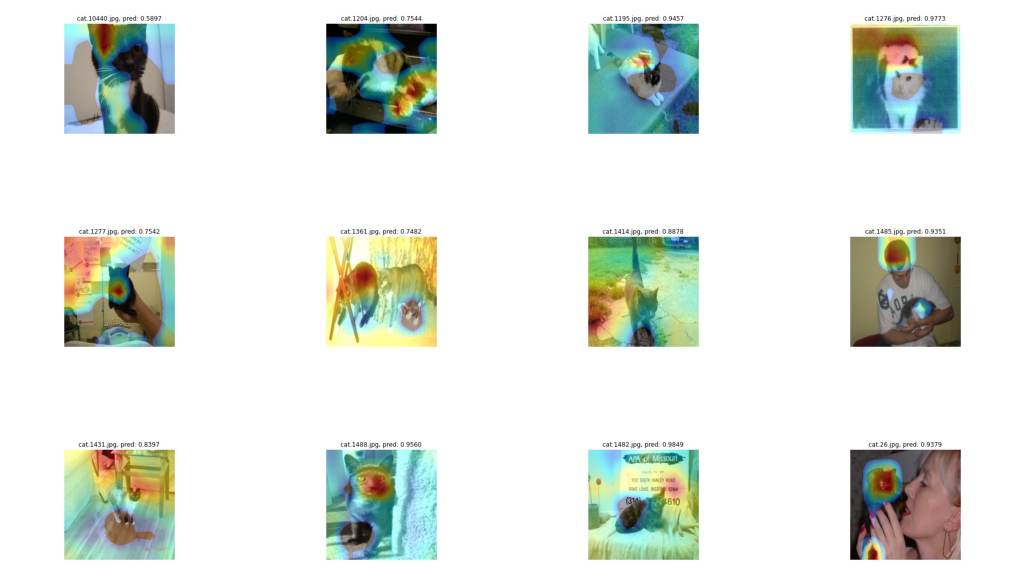

In [ ]:
final_grad_cam(cat_path, 1, cat_1_cam)

## 개

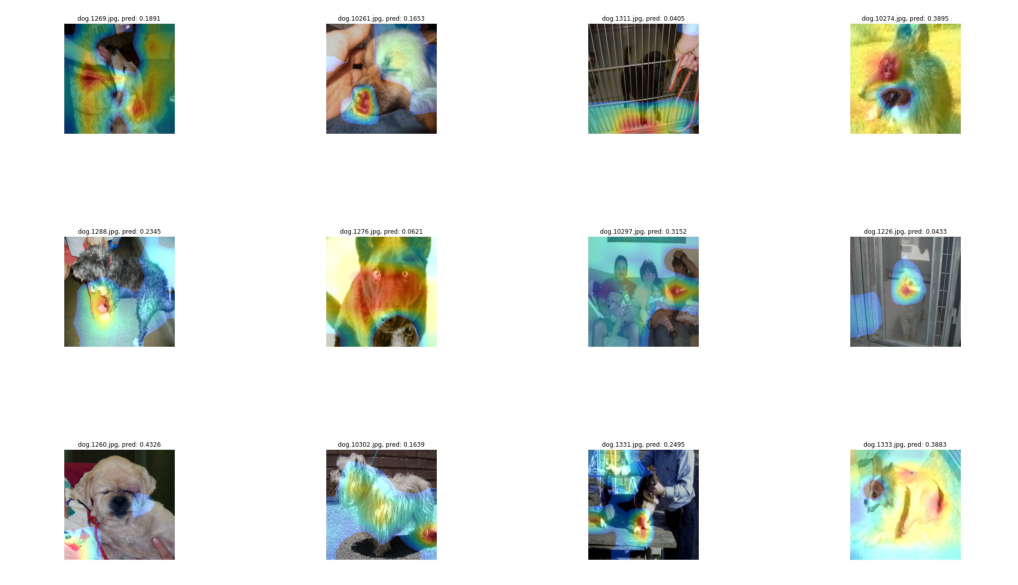

In [ ]:
final_grad_cam(dog_path, 0, dog_0_cam)

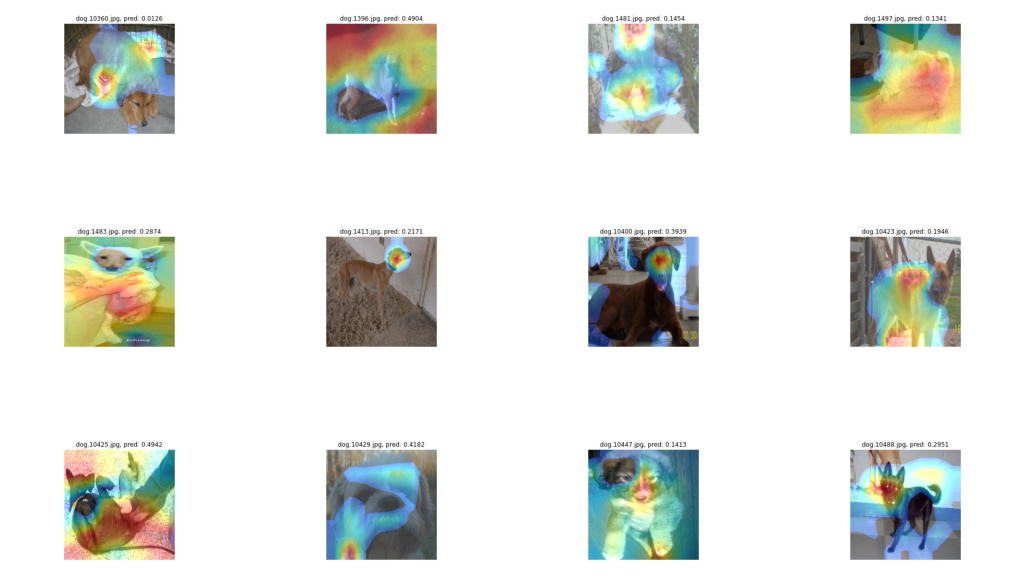

In [ ]:
final_grad_cam(dog_path, 0, dog_0_cam)